Copyright (c) 2019 Gopal Krishna. Released under the MIT License


In [ ]:
pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 4.9 MB/s eta 0:00:00


In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
        
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:

X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_13 (Conv3D)          (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_14 (Conv3D)          (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.6450 - accuracy: 0.1490

13/13 [==============================] - 13s 204ms/step - loss: 2.6450 - accuracy: 0.1490
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4352 - accuracy: 0.2168

13/13 [==============================] - 2s 191ms/step - loss: 2.4347 - accuracy: 0.2170
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 1.9608 - accuracy: 0.3542

13/13 [==============================] - 3s 192ms/step - loss: 1.9615 - accuracy: 0.3539
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 1.4897 - accuracy: 0.4977

13/13 [==============================] - 3s 191ms/step - loss: 1.4896 - accuracy: 0.4977
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 1.0234 - accuracy: 0.6481

13/13 [==============================] - 3s 196ms/step - loss: 1.0239 - accuracy: 0.6480
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 0.6570 - accuracy: 0.7806

13/13 [==============================] - 3s 196ms/step - loss: 0.6565 - accuracy: 0.7807
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3777 - accuracy: 0.8815

13/13 [==============================] - 3s 195ms/step - loss: 0.3774 - accuracy: 0.8816
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2275 - accuracy: 0.9326

13/13 [==============================] - 3s 195ms/step - loss: 0.2275 - accuracy: 0.9327
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1763 - accuracy: 0.9437

13/13 [==============================] - 3s 196ms/step - loss: 0.1762 - accuracy: 0.9437
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1280 - accuracy: 0.9606

13/13 [==============================] - 3s 198ms/step - loss: 0.1282 - accuracy: 0.9606
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1774 - accuracy: 0.9476

13/13 [==============================] - 3s 202ms/step - loss: 0.1773 - accuracy: 0.9476
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0943 - accuracy: 0.9723

13/13 [==============================] - 3s 197ms/step - loss: 0.0948 - accuracy: 0.9720
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2567 - accuracy: 0.9277

13/13 [==============================] - 3s 197ms/step - loss: 0.2565 - accuracy: 0.9278
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1516 - accuracy: 0.9603

13/13 [==============================] - 3s 199ms/step - loss: 0.1515 - accuracy: 0.9603
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0931 - accuracy: 0.9717

13/13 [==============================] - 3s 204ms/step - loss: 0.0958 - accuracy: 0.9714
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2592 - accuracy: 0.9251

13/13 [==============================] - 3s 204ms/step - loss: 0.2591 - accuracy: 0.9252
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1441 - accuracy: 0.9574

13/13 [==============================] - 3s 201ms/step - loss: 0.1440 - accuracy: 0.9574
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0652 - accuracy: 0.9831

13/13 [==============================] - 3s 207ms/step - loss: 0.0652 - accuracy: 0.9831
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0375 - accuracy: 0.9886

13/13 [==============================] - 3s 201ms/step - loss: 0.0375 - accuracy: 0.9886
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0265 - accuracy: 0.9919

13/13 [==============================] - 3s 203ms/step - loss: 0.0265 - accuracy: 0.9919
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0208 - accuracy: 0.9958

13/13 [==============================] - 3s 208ms/step - loss: 0.0208 - accuracy: 0.9958
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0248 - accuracy: 0.9935

13/13 [==============================] - 3s 204ms/step - loss: 0.0247 - accuracy: 0.9935
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0250 - accuracy: 0.9948

13/13 [==============================] - 3s 205ms/step - loss: 0.0249 - accuracy: 0.9948
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0112 - accuracy: 0.9964

13/13 [==============================] - 3s 205ms/step - loss: 0.0112 - accuracy: 0.9964
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0224 - accuracy: 0.9935

13/13 [==============================] - 3s 205ms/step - loss: 0.0224 - accuracy: 0.9935
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9958

13/13 [==============================] - 3s 207ms/step - loss: 0.0122 - accuracy: 0.9958
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0199 - accuracy: 0.9958

13/13 [==============================] - 3s 203ms/step - loss: 0.0199 - accuracy: 0.9958
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0146 - accuracy: 0.9941

13/13 [==============================] - 3s 202ms/step - loss: 0.0146 - accuracy: 0.9941
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0147 - accuracy: 0.9961

13/13 [==============================] - 3s 201ms/step - loss: 0.0147 - accuracy: 0.9961
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0114 - accuracy: 0.9977

13/13 [==============================] - 3s 202ms/step - loss: 0.0114 - accuracy: 0.9977
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0140 - accuracy: 0.9958

13/13 [==============================] - 3s 212ms/step - loss: 0.0140 - accuracy: 0.9958
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0071 - accuracy: 0.9971

13/13 [==============================] - 3s 200ms/step - loss: 0.0071 - accuracy: 0.9971
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0209 - accuracy: 0.9945

13/13 [==============================] - 3s 199ms/step - loss: 0.0209 - accuracy: 0.9945
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0219 - accuracy: 0.9941

13/13 [==============================] - 3s 199ms/step - loss: 0.0219 - accuracy: 0.9941
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9964

13/13 [==============================] - 3s 199ms/step - loss: 0.0139 - accuracy: 0.9964
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0136 - accuracy: 0.9961

13/13 [==============================] - 3s 201ms/step - loss: 0.0136 - accuracy: 0.9961
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9977

13/13 [==============================] - 3s 199ms/step - loss: 0.0074 - accuracy: 0.9977
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0047 - accuracy: 0.9990

13/13 [==============================] - 3s 199ms/step - loss: 0.0047 - accuracy: 0.9990
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0159 - accuracy: 0.9967

13/13 [==============================] - 3s 199ms/step - loss: 0.0159 - accuracy: 0.9967
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0152 - accuracy: 0.9945

13/13 [==============================] - 3s 198ms/step - loss: 0.0152 - accuracy: 0.9945
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0092 - accuracy: 0.9974

13/13 [==============================] - 3s 203ms/step - loss: 0.0092 - accuracy: 0.9974
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0165 - accuracy: 0.9961

13/13 [==============================] - 3s 204ms/step - loss: 0.0164 - accuracy: 0.9961
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0099 - accuracy: 0.9971

13/13 [==============================] - 3s 202ms/step - loss: 0.0099 - accuracy: 0.9971
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9974

13/13 [==============================] - 3s 199ms/step - loss: 0.0117 - accuracy: 0.9974
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9977

13/13 [==============================] - 3s 199ms/step - loss: 0.0123 - accuracy: 0.9977
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0100 - accuracy: 0.9974

13/13 [==============================] - 3s 202ms/step - loss: 0.0100 - accuracy: 0.9974
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0112 - accuracy: 0.9971

13/13 [==============================] - 3s 200ms/step - loss: 0.0112 - accuracy: 0.9971
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0122 - accuracy: 0.9974

13/13 [==============================] - 3s 199ms/step - loss: 0.0122 - accuracy: 0.9974
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9967

13/13 [==============================] - 3s 200ms/step - loss: 0.0139 - accuracy: 0.9967
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0060 - accuracy: 0.9984
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0132 - accuracy: 0.9984

13/13 [==============================] - 3s 205ms/step - loss: 0.0132 - accuracy: 0.9984
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984

13/13 [==============================] - 3s 202ms/step - loss: 0.0060 - accuracy: 0.9984
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9990

13/13 [==============================] - 3s 201ms/step - loss: 0.0038 - accuracy: 0.9990
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0073 - accuracy: 0.9974

13/13 [==============================] - 3s 201ms/step - loss: 0.0072 - accuracy: 0.9974
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993

13/13 [==============================] - 3s 201ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984

13/13 [==============================] - 3s 205ms/step - loss: 0.0057 - accuracy: 0.9984
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

13/13 [==============================] - 3s 203ms/step - loss: 0.0077 - accuracy: 0.9980
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990

13/13 [==============================] - 3s 200ms/step - loss: 0.0028 - accuracy: 0.9990
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9980

13/13 [==============================] - 3s 200ms/step - loss: 0.0050 - accuracy: 0.9980
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.9971

13/13 [==============================] - 3s 201ms/step - loss: 0.0117 - accuracy: 0.9971
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980

13/13 [==============================] - 3s 202ms/step - loss: 0.0059 - accuracy: 0.9980
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0053 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0053 - accuracy: 0.9980
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0040 - accuracy: 0.9984
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9997

13/13 [==============================] - 3s 200ms/step - loss: 0.0029 - accuracy: 0.9997
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9987

13/13 [==============================] - 3s 200ms/step - loss: 0.0062 - accuracy: 0.9987
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0098 - accuracy: 0.9974

13/13 [==============================] - 3s 203ms/step - loss: 0.0098 - accuracy: 0.9974
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0073 - accuracy: 0.9990

13/13 [==============================] - 3s 203ms/step - loss: 0.0073 - accuracy: 0.9990
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0099 - accuracy: 0.9980

13/13 [==============================] - 3s 200ms/step - loss: 0.0099 - accuracy: 0.9980
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9987

13/13 [==============================] - 3s 199ms/step - loss: 0.0038 - accuracy: 0.9987
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0039 - accuracy: 0.9984
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0080 - accuracy: 0.9984

13/13 [==============================] - 3s 202ms/step - loss: 0.0080 - accuracy: 0.9984
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9990

13/13 [==============================] - 3s 203ms/step - loss: 0.0062 - accuracy: 0.9990
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0057 - accuracy: 0.9984
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990

13/13 [==============================] - 3s 199ms/step - loss: 0.0031 - accuracy: 0.9990
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0080 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0080 - accuracy: 0.9984
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0082 - accuracy: 0.9984
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0036 - accuracy: 0.9987

13/13 [==============================] - 3s 202ms/step - loss: 0.0036 - accuracy: 0.9987
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - accuracy: 0.9990

13/13 [==============================] - 3s 200ms/step - loss: 0.0027 - accuracy: 0.9990
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9987

13/13 [==============================] - 3s 200ms/step - loss: 0.0057 - accuracy: 0.9987
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9964

13/13 [==============================] - 3s 200ms/step - loss: 0.0133 - accuracy: 0.9964
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0066 - accuracy: 0.9980
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0090 - accuracy: 0.9977

13/13 [==============================] - 3s 202ms/step - loss: 0.0090 - accuracy: 0.9977
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0032 - accuracy: 0.9993

13/13 [==============================] - 3s 199ms/step - loss: 0.0032 - accuracy: 0.9993
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9990

13/13 [==============================] - 3s 200ms/step - loss: 0.0046 - accuracy: 0.9990
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0070 - accuracy: 0.9980

13/13 [==============================] - 3s 200ms/step - loss: 0.0070 - accuracy: 0.9980
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0078 - accuracy: 0.9971

13/13 [==============================] - 3s 203ms/step - loss: 0.0078 - accuracy: 0.9971
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.9967

13/13 [==============================] - 3s 202ms/step - loss: 0.0089 - accuracy: 0.9967
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984

13/13 [==============================] - 3s 199ms/step - loss: 0.0057 - accuracy: 0.9984
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993

13/13 [==============================] - 3s 200ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0047 - accuracy: 0.9980

13/13 [==============================] - 3s 199ms/step - loss: 0.0047 - accuracy: 0.9980
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9987

13/13 [==============================] - 3s 201ms/step - loss: 0.0029 - accuracy: 0.9987
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0064 - accuracy: 0.9984

13/13 [==============================] - 3s 203ms/step - loss: 0.0064 - accuracy: 0.9984
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

13/13 [==============================] - 3s 200ms/step - loss: 0.0075 - accuracy: 0.9980
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0048 - accuracy: 0.9987

13/13 [==============================] - 3s 200ms/step - loss: 0.0048 - accuracy: 0.9987
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993

13/13 [==============================] - 3s 199ms/step - loss: 0.0024 - accuracy: 0.9993
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0028 - accuracy: 0.9984
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9987

13/13 [==============================] - 3s 204ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0147 - accuracy: 0.9964

13/13 [==============================] - 3s 200ms/step - loss: 0.0147 - accuracy: 0.9964
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0164 - accuracy: 0.9961

13/13 [==============================] - 3s 199ms/step - loss: 0.0164 - accuracy: 0.9961
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.9974

13/13 [==============================] - 3s 199ms/step - loss: 0.0089 - accuracy: 0.9974


In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

OSError: ignored

In [ ]:

Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.99      0.99      0.99      1000
           2       1.00      0.99      0.99       581
           3       0.98      1.00      0.99       166
           4       0.99      0.98      0.98       338
           5       0.99      1.00      0.99       511
           6       1.00      0.95      0.97        20
           7       1.00      1.00      1.00       335
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00       680
          10       1.00      0.99      1.00      1719
          11       1.00      0.99      1.00       415
          12       0.96      1.00      0.98       143
          13       0.99      1.00      1.00       886
          14       1.00      0.99      0.99       270
          15       0.97      1.00      0.98        65

    accuracy            

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 3s 12ms/step - loss: 0.0250 - accuracy: 0.9943


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
1/1 [==============================] - 0s 26ms/step


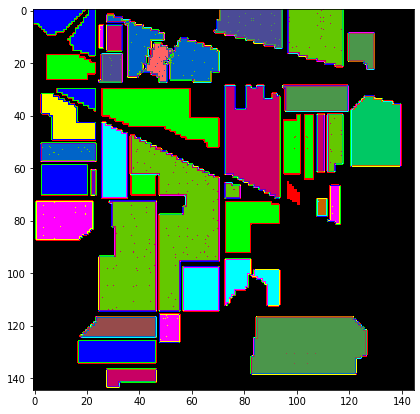

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

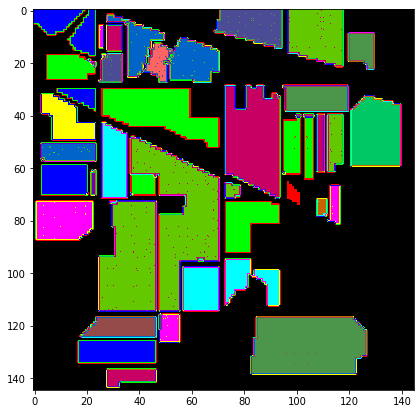

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

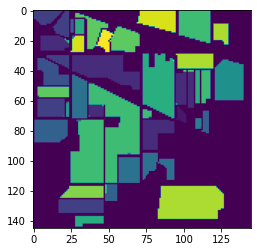

In [ ]:
gt_pred=outputs
plt.imshow(gt_pred)
labels = sio.loadmat("Indian_pines_ground_truth.mat")['indian_pines_gt']


In [ ]:
from keras.metrics import MeanIoU 
IOU_mean=MeanIoU(num_classes=17)
IOU_mean.update_state(gt_pred,labels)
print(IOU_mean.result().numpy())

0.9867381
